<a href="https://colab.research.google.com/github/TalCordova/TensorFlow_Course/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose fot this notebbok is to build an NLP model to make redaing medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is avilable here: https://arxiv.org/abs/1710.06071
.

And reading through the paper above, we see that the model architecture that they use to achieve their best results is avilable here: https://arxiv.org/abs/1612.05251.

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-af967ac6-d69c-900f-1569-6d1e98dae06d)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT) let's download the dataset they used. 

We can do this from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with number replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Check all the filenames in the target directpry
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best wayes to become one with the data is to...
> Visualize, visualize, visualize

So, with that in mind, le'ts write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string contianing the target path.

  Returns
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()



In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"/train.txt") # read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_numebr': 0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines': 11},
  ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 835 ms, sys: 126 ms, total: 961 ms
Wall time: 1.76 s


In [ ]:
# Check the first abstract of the training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the form of a list of dicrionaries, how about we turn into a DataFrame to further visualize it

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

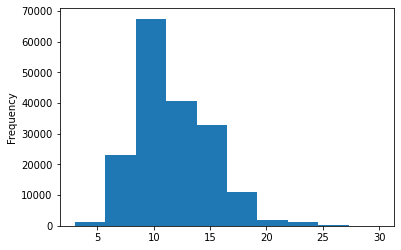

In [ ]:
# Let's check the length of different line
train_df.total_lines.plot.hist();

### Get list of sentences

In [ ]:
# Convert abstract text line into list
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first line of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Staeting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always' we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a basline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipline
model_0 = Pipeline([
    ("td-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences, 
            y = train_labels_encoded)

Pipeline(steps=[('td-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
                y = val_labels_encoded)

0.7218323844829869

In [ ]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across differnt metrics (accuracy, precision, recall ,f1) and rather than rewriting it here, let's download it from helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-30 12:08:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-30 12:08:35 (86.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to crate vectorization and embedding kayers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

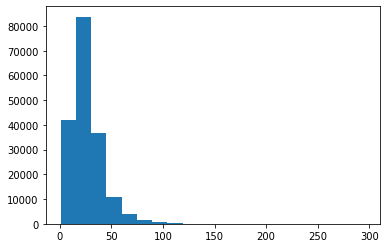

In [ ]:
# What's the distributon looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Max sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps out text from words to numbers.

In [ ]:
# How many words are in our vocabulary? (taken from table 2 in: https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of wards in vocabulary
                                    output_sequence_length = output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
@f-fdg pet can be used to aid in the diagnosis of alzheimer 's disease ( ad ) and clarify the diagnosis and prognosis of patients with mild cognitive impairment ( mci ) .

Length of text: 33

Vectorized text: [[9176 5117  171   36   98    6 2153    5    2  536    4 2730  130  114
  1246    3 3920    2  536    3 1865    4   12    7  533  301  798 5194
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words are in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                                output_dim = 128, # Note: different embedding sizes result in drastocally different number of parameters to train
                                mask_zero = True, # use masking to handle variable sequences length (save space)
                                name = "token_embedding")

In [ ]:
# Show example embdding
print(f"Sentence befor embedding:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vactorization (before embedding:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence befor embedding:
 @f-fdg pet can be used to aid in the diagnosis of alzheimer 's disease ( ad ) and clarify the diagnosis and prognosis of patients with mild cognitive impairment ( mci ) .

Sentence after vactorization (before embedding:
 [[9176 5117  171   36   98    6 2153    5    2  536    4 2730  130  114
  1246    3 3920    2  536    3 1865    4   12    7  533  301  798 5194
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.03039274 -0.00107983 -0.02518002 ... -0.04926094  0.01401501
   -0.04884161]
  [ 0.04960065  0.01909948  0.03591868 ... -0.01821756 -0.01768466
    0.01614264]
  [-0.03535683  0.04967977  0.04673554 ... -0.04108232 -0.03143487
   -0.00045953]
  ...
  [-0.04746975  0.01676947  0.04001449 ... -0.03165089 -0.00834237
    0.00652019]
  [-0.04746975  0.01676947  0.04001449 ... -0.03165089 -0.00834237
    0.00652019]
  [-0.04746975  0.

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup out data to run as fast as possible with the TensorFlow tf.data API, many of the steps are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the tensor slice datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condende the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9238 - accuracy: 0.6348 - val_loss: 0.6938 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6635 - accuracy: 0.7530 - val_loss: 0.6381 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6215 - accuracy: 0.7730 - val_loss: 0.5997 - val_accuracy: 0.7852


In [ ]:
# Evaluating on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.6009 - accuracy: 0.7845


[0.6008607745170593, 0.7844564914703369]

In [ ]:
#Make predictions (our model predics probabilities for each classs)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.3414077e-01, 1.7907470e-01, 8.6081818e-02, 2.7518198e-01,
         2.5520761e-02],
        [4.3099883e-01, 3.0285281e-01, 1.4263198e-02, 2.4297969e-01,
         8.9055691e-03],
        [1.4120507e-01, 7.2308574e-03, 1.5469575e-03, 8.4997112e-01,
         4.6006153e-05],
        ...,
        [4.6681953e-06, 6.9260394e-04, 5.3408748e-04, 3.5681087e-06,
         9.9876511e-01],
        [6.3856713e-02, 4.7840753e-01, 9.3068011e-02, 7.0143454e-02,
         2.9452419e-01],
        [1.6740201e-01, 6.4888358e-01, 4.8651230e-02, 4.5565143e-02,
         8.9498088e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Caluclate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.44565073480736,
 'precision': 0.7808433699586339,
 'recall': 0.7844565073480736,
 'f1': 0.7820182557885071}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable = False,
                                 name = "univerasl_sentence_encoder")

In [ ]:
# Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentences:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentences:
 in multivariate analysis evaluating renal events requiring treatment modification , only baseline hiv-@ rna and creatinine clearance were significantly associated ( or @ , @ % ci @ , @ per @ log@ copies/ml higher ; p = @ and or @ , @ % ci @ , @ per @ ml/min higher ; p = @ , respectively ) .
Sentence after embedding:
[-0.01887463 -0.07004075 -0.00915665 -0.04250982  0.00487534 -0.05968843
  0.02977102 -0.05585526  0.0126788   0.0430259   0.07561059  0.04199981
 -0.00795781 -0.02316797  0.0522865  -0.05911454 -0.07449812  0.05867884
  0.07139623  0.0306546   0.07271497  0.05288369 -0.04879884 -0.01023683
  0.05834173  0.04712786 -0.02391779  0.01884743 -0.05974758 -0.05986937]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub


In [ ]:
# Define feature extraction model
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 univerasl_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9110 - accuracy: 0.6545 - val_loss: 0.7941 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7685 - accuracy: 0.7027 - val_loss: 0.7539 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7519 - accuracy: 0.7129 - val_loss: 0.7383 - val_accuracy: 0.7131


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7408 - accuracy: 0.7143


[0.7407712936401367, 0.7142857313156128]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.43987864, 0.35207763, 0.00234281, 0.19807707, 0.0076239 ],
       [0.3450277 , 0.53306025, 0.00408049, 0.1150621 , 0.00276944],
       [0.25100586, 0.1466485 , 0.0204841 , 0.5444579 , 0.03740363],
       ...,
       [0.00197931, 0.00825822, 0.06233662, 0.00106191, 0.92636395],
       [0.00392084, 0.05254015, 0.22100227, 0.00150203, 0.7210347 ],
       [0.16739492, 0.27767283, 0.49811935, 0.00561787, 0.05119499]],
      dtype=float32)

In [ ]:
# Convert the predictions probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF HUB pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.42857142857143,
 'precision': 0.7143776899915303,
 'recall': 0.7142857142857143,
 'f1': 0.7111745751558322}

## Model 3: Conv1D with character embedding

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously, we've token-level embedding but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a character level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-chracter-level sequence into characters
split_chars(random_train_sentence)

'i n   m u l t i v a r i a t e   a n a l y s i s   e v a l u a t i n g   r e n a l   e v e n t s   r e q u i r i n g   t r e a t m e n t   m o d i f i c a t i o n   ,   o n l y   b a s e l i n e   h i v - @   r n a   a n d   c r e a t i n i n e   c l e a r a n c e   w e r e   s i g n i f i c a n t l y   a s s o c i a t e d   (   o r   @   ,   @   %   c i   @   ,   @   p e r   @   l o g @   c o p i e s / m l   h i g h e r   ;   p   =   @   a n d   o r   @   ,   @   %   c i   @   ,   @   p e r   @   m l / m i n   h i g h e r   ;   p   =   @   ,   r e s p e c t i v e l y   )   .'

In [ ]:
# Split sequence-level data into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars[:5]

['i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'i t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .',
 'w e   s o u g h t   t o   d e t e r m i n e   w h e t h e r   a   @ - m o n t h   c o u r s e   o f   v o r i c o n a z o l e   i m p r o v e d   a s t h m a - r e l a t e d   o u t c o m e s   i n   p a t i e n t s   w i t h   a s t h m a   w h o   a r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   .',
 'a s t h m a t i c   p a t i e n t s   w h o   w e r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   w i t h   a   h i s t o r y   o f   a t   l e a s t   @   s e v e r e   e x a c e r b a t i o n s   i n   t h e   p r e v 

In [ ]:
# What's the average chcrater length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

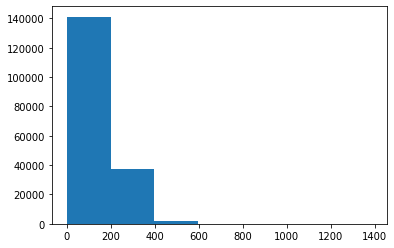

In [ ]:
# Check the distribution of oue sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins = 7)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # ass 2 for space and OOV (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    # standardize = None, # set standarztion to None, if you want to leave puncuation in
                                    name = "char_vectorizer")

In [ ]:
# Adapt chcrater vectorizer to training chracters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocad stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Chrified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vactorized chars: {len(vectorized_chars[0])}")

Chrified text:
 i n f e c t i o n s   a n d   i n c r e a s e s   i n   l i v e r   t r a n s a m i n a s e   a n d   l i p i d   l e v e l s   w e r e   n o t e d   a s   p o t e n t i a l   s a f e t y   s i g n a l s   .

Length of random_train_chars: 89

Vectorized chars:
 [[ 4  6 17  2 11  3  4  7  6  9  5  6 10  4  6 11  8  2  5  9  2  9  4  6
  12  4 21  2  8  3  8  5  6  9  5 15  4  6  5  9  2  5  6 10 12  4 14  4
  10 12  2 21  2 12  9 20  2  8  2  6  7  3  2 10  5  9 14  7  3  2  6  3
   4  5 12  9  5 17  2  3 19  9  4 18  6  5 12  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a character level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25, # this is the char embedding the in paper https://arxiv.org/abs/1612.05251 (Figure 1)
                              mask_zero = True,
                              name = "char_embed")

In [ ]:
# Test out character embedding layer
print(f"Cgarified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding:\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Cgarified text:
 i n f e c t i o n s   a n d   i n c r e a s e s   i n   l i v e r   t r a n s a m i n a s e   a n d   l i p i d   l e v e l s   w e r e   n o t e d   a s   p o t e n t i a l   s a f e t y   s i g n a l s   .

Embedded chars. (after vectorization and embedding:
 [[[-0.02004734  0.02186629  0.02676496 ...  0.03398005 -0.04187484
   -0.02909129]
  [ 0.00792521 -0.04698799  0.01816166 ... -0.00622324 -0.0139879
    0.02889785]
  [ 0.01891686 -0.04774469 -0.04075465 ... -0.04226536  0.03105476
    0.01780871]
  ...
  [-0.01363755  0.04512856 -0.01281746 ...  0.00800405 -0.04419364
   -0.01796343]
  [-0.01363755  0.04512856 -0.01281746 ...  0.00800405 -0.04419364
   -0.01796343]
  [-0.01363755  0.04512856 -0.01281746 ...  0.00800405 -0.04419364
   -0.01796343]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Coinv1D on chars onlt
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_3_conv1d_char_embedding")

# Compile
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2713 - accuracy: 0.4876 - val_loss: 1.0512 - val_accuracy: 0.5881
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0037 - accuracy: 0.5985 - val_loss: 0.9377 - val_accuracy: 0.6283
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9260 - accuracy: 0.6354 - val_loss: 0.8631 - val_accuracy: 0.6672


In [ ]:
# Make predictions with charater model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.13681   , 0.36788929, 0.10761072, 0.314327  , 0.07336295],
       [0.23882717, 0.24628846, 0.04227634, 0.4246464 , 0.04796164],
       [0.23664227, 0.16158898, 0.13589814, 0.4251434 , 0.04072715],
       ...,
       [0.01854246, 0.02221325, 0.17951511, 0.01761083, 0.7621184 ],
       [0.0854697 , 0.30070212, 0.2943752 , 0.06413449, 0.25531846],
       [0.4183479 , 0.37353167, 0.0827453 , 0.10344435, 0.02193085]],
      dtype=float32)

In [ ]:
# Convert preeicitons probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 1, 0])>

In [ ]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.55342248113332,
 'precision': 0.6526992303693387,
 'recall': 0.6555342248113333,
 'f1': 0.6459353747490197}

## Model 4: Combining pretrained token embeddings + chcracters embeddings (hybrid embedding layer)

1. Create token level embedding model (similar to `model_1`)
2. Create character level model (similar to `model_3` with a slight modification)
3. Combine 1&2 with a concatenate layer (`layer.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/abs/1612.05251
5. Construct a model which takes token and character-level sequence as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup the token inputs/model
token_inputs = layers.input = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Setup char inputs\model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in figure 1 of https://arxiv.org/abs/1612.05251
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout, discessed in section 4.2 of https://arxiv.org/abs/1612.05251
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Contsruct with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name= "model_4_token_and_char_embeddings")

In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 univerasl_sentence_encoder (Ke  (None, 512)         256797824   [

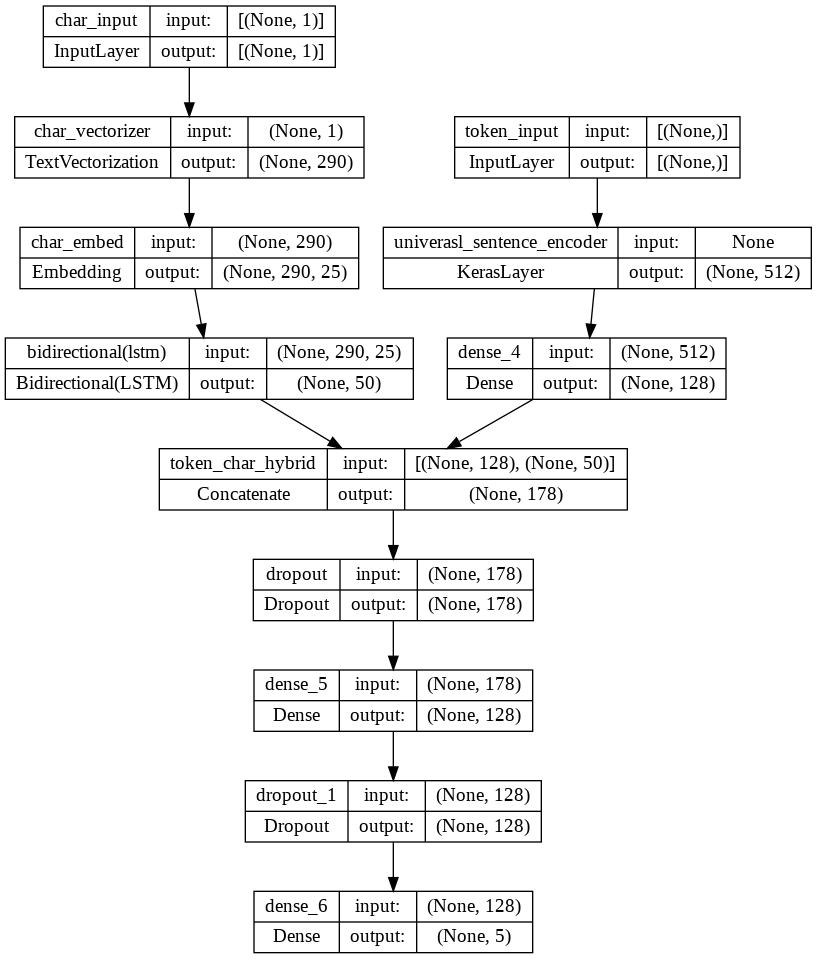

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, but we'll stick with Adam
                metrics = ["accuracy"])

### Combining token and character data into a tf.Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make the labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# prefetch and batch data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Repeat the above steps for validation
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make the labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 60ms/step - loss: 0.9822 - accuracy: 0.6112 - val_loss: 0.7863 - val_accuracy: 0.6988
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.8022 - accuracy: 0.6871 - val_loss: 0.7100 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7753 - accuracy: 0.7022 - val_loss: 0.6843 - val_accuracy: 0.7410


In [ ]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 25s 27ms/step - loss: 0.6921 - accuracy: 0.7368


[0.692138135433197, 0.7368264198303223]

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 26s 25ms/step


array([[4.1822129e-01, 3.8195476e-01, 5.1567205e-03, 1.8552765e-01,
        9.1395602e-03],
       [3.2022205e-01, 4.6771851e-01, 2.7372926e-03, 2.0772699e-01,
        1.5952248e-03],
       [2.5552896e-01, 6.3502714e-02, 3.5952095e-02, 6.2883854e-01,
        1.6177703e-02],
       ...,
       [5.6216901e-04, 9.1258045e-03, 4.2758726e-02, 1.8670120e-04,
        9.4736660e-01],
       [5.7144235e-03, 7.5051971e-02, 1.5672427e-01, 2.3313391e-03,
        7.6017797e-01],
       [2.2290868e-01, 3.2501099e-01, 3.3166811e-01, 3.0856516e-02,
        8.9555725e-02]], dtype=float32)

In [ ]:
# Convert preeicitons probabilities to class labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Get results of token char hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_4_preds)
model_4_results

{'accuracy': 73.68264265854627,
 'precision': 0.7355710312285413,
 'recall': 0.7368264265854627,
 'f1': 0.7336294764089305}

## Model 5: Trasfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

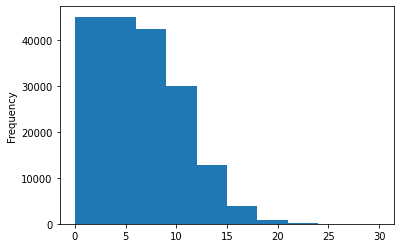

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line numbers features, let's the same for our total lines feature

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

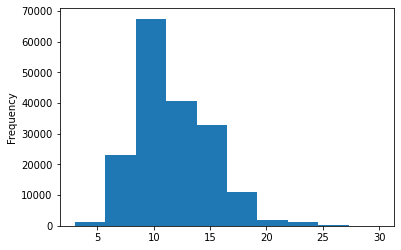

In [ ]:
# Check distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines"
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of or "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output layer probabilities
8. Combine the inputs of 1, 2, 3, 4 and output into `tf.keras.Model`

In [ ]:
from re import X
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
toekn_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Create char inputs
char_inputs = layers.Input(shape = (1,), dtype = "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lastm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lastm)

# 3. Line number model
# inputs shape = ?
line_number_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = "line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation = "relu")(line_number_inputs)
# combine inputs & dense layer into a model
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.float32 ,name = "total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)

# 5. Combine token and char embedding into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_toekn_hybrid_embeddings")([token_model.output,
                                                                                 char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embeddings")([line_number_model.output,
                                                                                    total_lines_model.output,
                                                                                    z])

# 7. Create output layer
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together a model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "model_5_tribrid_embeddings_model")

In [ ]:
# Get a summary of our tribrid embeddings model
model_5.summary()

Model: "model_5_tribrid_embeddings_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 univerasl_sentence_encoder (Ke  (None, 512)         256797824   ['

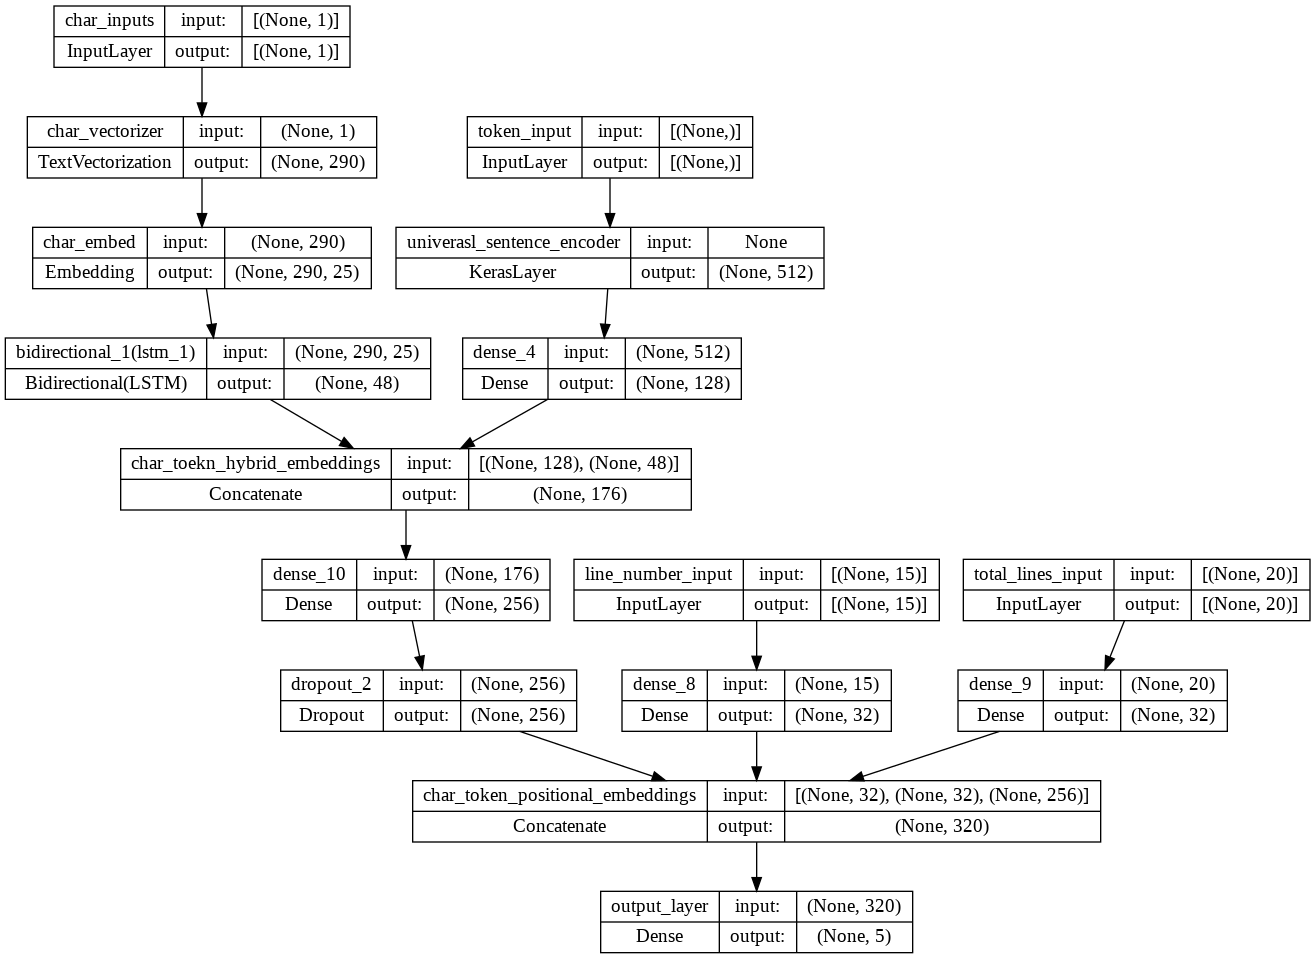

In [ ]:
# Plot the model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization : `[0.01, 0.01, 0.96, 0.01, 0.01]`

> For more on label smoothing, see this blog post from PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile token, char and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Create tribrid embedding datasets using `tf.data`

In [ ]:
# Create training and validation datasets  (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars)) # make data - the order matters, the same as in the building of the model!!
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make the labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)) # combine data and labels
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fitting, evaluating and making predictions with the tribrid model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 59ms/step - loss: 1.0515 - accuracy: 0.7595 - val_loss: 0.9717 - val_accuracy: 0.8145
Epoch 2/3
562/562 [==============================] - 30s 54ms/step - loss: 0.9530 - accuracy: 0.8267 - val_loss: 0.9412 - val_accuracy: 0.8331
Epoch 3/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9403 - accuracy: 0.8286 - val_loss: 0.9358 - val_accuracy: 0.8311


In [ ]:
# Evaluate model_5
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 25s 26ms/step - loss: 0.9323 - accuracy: 0.8351


[0.9322797060012817, 0.8350655436515808]

In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 26s 25ms/step


array([[0.48899207, 0.10245715, 0.01212572, 0.37970677, 0.01671824],
       [0.5606143 , 0.10658589, 0.04150696, 0.28373426, 0.00755856],
       [0.29314047, 0.1075172 , 0.13077651, 0.41313103, 0.05543485],
       ...,
       [0.03115628, 0.11989829, 0.03560809, 0.02631236, 0.787025  ],
       [0.03151901, 0.29855   , 0.0757621 , 0.02661523, 0.5675536 ],
       [0.16003187, 0.6869578 , 0.05193035, 0.03994685, 0.06113315]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char token pos model_5 results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.50655368727658,
 'precision': 0.8344933866082068,
 'recall': 0.8350655368727657,
 'f1': 0.8340999376449241}

## Comapare model results

In [ ]:
# Combine model results into a dataframe
import pandas as pf
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embeddings": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.445651,0.780843,0.784457,0.782018
model_2_pretrained_token_embedding,71.428571,0.714378,0.714286,0.711175
model_3_custom_char_embeddings,65.553422,0.652699,0.655534,0.645935
model_4_hybrid_char_token_embedding,73.682643,0.735571,0.736826,0.733629
model_5_pos_char_token_embedding,83.506554,0.834493,0.835066,0.834100


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

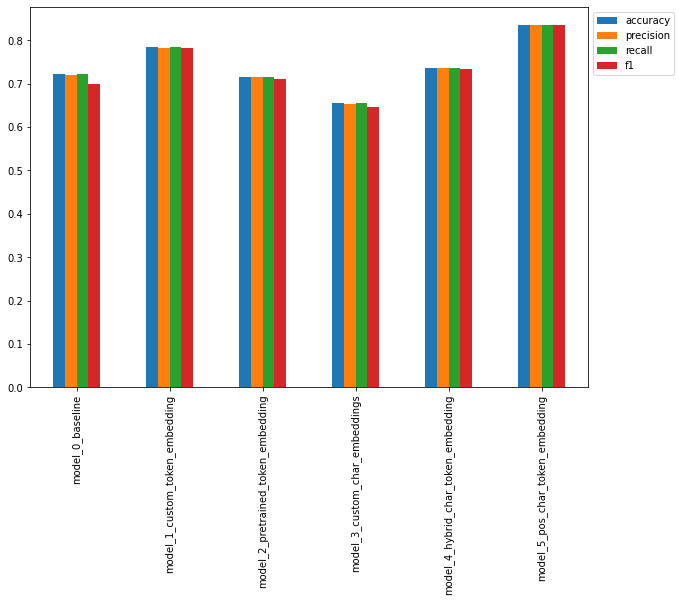

In [ ]:
all_model_results.plot(kind = "bar", figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0))

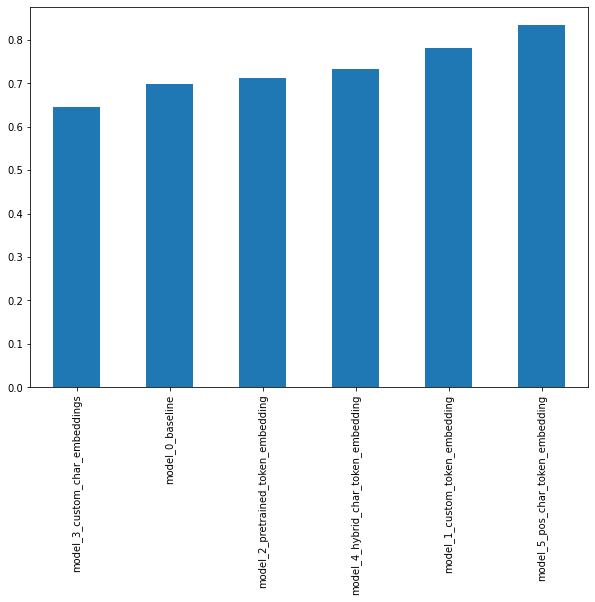

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

## Save and load model

In [ ]:
# Save the best perfoeming model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_model_pred_probs, axis = 1)
loaded_preds[:10]

945/945 [==============================] - 27s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of the loaded model
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)
loaded_model_results

{'accuracy': 83.50655368727658,
 'precision': 0.8344933866082068,
 'recall': 0.8350655368727657,
 'f1': 0.8340999376449241}

In [ ]:
model_5_results

{'accuracy': 83.50655368727658,
 'precision': 0.8344933866082068,
 'recall': 0.8350655368727657,
 'f1': 0.8340999376449241}

## Downloaded and load in pretrained model from Google storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-11-30 09:09:48--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  59.2MB/s    in 11s     

2022-11-30 09:09:59 (81.4 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_m

## Your cahllenges

1. Turn the test data samples into a tf.dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example precitions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 abstracts from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json

### 1. Turn test data into dataset, predict and evalutate on test dataset

In [ ]:
# 1. turn test data to tf.dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars)) # make data - the order matters, the same as in the building of the model!!
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make the labels
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels)) # combine data and labels
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
test_pred_probs

942/942 [==============================] - 33s 35ms/step


array([[0.37794626, 0.06971575, 0.03778719, 0.46476197, 0.04978891],
       [0.36140835, 0.06627411, 0.22119702, 0.30762467, 0.04349591],
       [0.06294489, 0.0211012 , 0.7809119 , 0.09125089, 0.04379111],
       ...,
       [0.08255077, 0.0874154 , 0.09112295, 0.061313  , 0.6775979 ],
       [0.06945601, 0.10828905, 0.08036499, 0.04950301, 0.692387  ],
       [0.10255963, 0.54836303, 0.15471011, 0.04784979, 0.14651743]],
      dtype=float32)

In [ ]:
test_preds = tf.argmax(test_pred_probs, axis = 1)
test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 0, 2, ..., 4, 4, 1])>

In [ ]:
test_results = calculate_results(y_true = test_label_encoded,
                                 y_pred = test_preds)
test_results

{'accuracy': 82.94673967147834,
 'precision': 0.8282517454261304,
 'recall': 0.8294673967147834,
 'f1': 0.8283969405201692}

### Find the most wrong predictions from 1

In [ ]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
# Get the labels of the test preds
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

Now we need to add a few values to the dataframe:
* The `test_pred_classes`
* The prediciton probabilty
* A boolean column that says if right or wrong

In [ ]:
test_df["pred_class"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis = 1).numpy()
test_df["correct"] = test_df["target"] == test_df["pred_class"]
test_df.head(20)

,target,text,line_number,total_lines,pred_class,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.464762,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.361408,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.780912,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.648300,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.747680,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.893656,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.550136,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.453931,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.480125,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.547333,True


In [ ]:
wrong_samples = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending = False)[:100]
wrong_samples

,target,text,line_number,total_lines,pred_class,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.942055,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.936884,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.930677,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.926728,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.918835,False
...,...,...,...,...,...,...,...
12575,BACKGROUND,the device was used to transmit weekly blood g...,3,11,METHODS,0.831720,False
546,RESULTS,"primarily , we assessed the difference between...",3,13,METHODS,0.831424,False
12846,RESULTS,m-ami and m-aci demonstrated very good-to-exce...,12,14,CONCLUSIONS,0.831145,False
12145,RESULTS,limitations of this study include a lack of ac...,13,16,CONCLUSIONS,0.831125,False


Now we can investigate the most wrong samples

In [ ]:
for row in wrong_samples[:10].itertuples():
  _, target, text, line_number, total_lines, pred_class, pred_prob, _ = row
  print(f"Target: {target}, Pred: {pred_class}, Pred prob: {pred_prob: .2f}, Line number:{line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n {text}\n")
  print("\n---\n")

Target: BACKGROUND, Pred: OBJECTIVE, Pred prob:  0.94, Line number:0, Total lines: 12

Text:
 to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .


---

Target: RESULTS, Pred: METHODS, Pred prob:  0.94, Line number:4, Total lines: 13

Text:
 the primary endpoint is the cumulative three-year hiv incidence .


---

Target: METHODS, Pred: BACKGROUND, Pred prob:  0.93, Line number:1, Total lines: 11

Text:
 pretest-posttest .


---

Target: CONCLUSIONS, Pred: METHODS, Pred prob:  0.93, Line number:4, Total lines: 6

Text:
 symptom outcomes will be assessed and estimates of cost-effectiveness made .


---

Target: RESULTS, Pred: METHODS, Pred prob:  0.92, Line number:3, Total lines: 16

Text:
 a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .


---

Target: BACKGROUND, Pred: OBJECTIVE, Pred prob:  0.91, Line number:0, Total lines: 11

Text:
 to assess the tempor

### Make example prediction


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
import json

with open("skimlit_example_abstracts.json", "r") as f:
  new_samples = json.load(f)

new_samples

--2022-11-30 13:14:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.2’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-11-30 13:14:12 (62.5 MB/s) - ‘skimlit_example_abstracts.json.2’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(new_samples)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# pass one sample abstract from the examples
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe("sentencizer")
doc = nlp(abstracts["abstract"][0]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
total_sample_lines = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_sample_lines - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all the values needed fro the model
sample_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(sample_line_numbers, depth = 15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all the total_lines from the abstract
sample_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(sample_total_lines, depth = 20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Now we need to split into chars for the char input
abstract_chars = [split_chars(sentence["text"]) for sentence in sample_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Predict with model_5
example_abstract_pred_probs = model_5.predict(x = (test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
example_abstract_pred_probs

1/1 [==============================] - 3s 3s/step


array([[0.32452008, 0.11639304, 0.01812882, 0.5157601 , 0.025198  ],
       [0.090744  , 0.02985438, 0.68091786, 0.10198379, 0.09649994],
       [0.14591108, 0.05331316, 0.5007067 , 0.20074688, 0.09932226],
       [0.09638061, 0.18960677, 0.5322653 , 0.07109233, 0.11065499],
       [0.04618805, 0.08697357, 0.42461935, 0.05117994, 0.39103916],
       [0.03836667, 0.10943422, 0.45622927, 0.04966452, 0.34630537],
       [0.0259233 , 0.15113433, 0.09044709, 0.02443954, 0.70805573],
       [0.02051301, 0.093381  , 0.21461445, 0.03605903, 0.6354325 ]],
      dtype=float32)

In [ ]:
# Convert pred probs to classes
example_abstracts_pred = tf.argmax(example_abstract_pred_probs, axis = 1)
example_abstracts_pred

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
# Turn preds back into text
example_abstract_pred_classes = [label_encoder.classes_[i] for i in example_abstracts_pred]
example_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{example_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
